# Running comparative analysis of multiple conditions

In order to compare multiple conditions and perform operations on them, we create a 'median reference' condition and compare all conditions in the dataset against the median condition. This then allows to do comparative analyses, such as heatmaps or general significance analyses (similar to ANOVA analyses on multiple conditions).


## Specifying input files

In order to run differential analyses you need two types of files:
* an input file from a proteomics search engine (e.g. DIA-NN, Spectronaut, AlphaPept etc.), or a pre-formatted file
* a sample mapping file that maps each sample to a condition (e.g.  sample 'brain_replicate_1' is mapped to condition 'brain'). In the GUI, there is some functionality to help create such a file

For the results file, AlphaQuant is compatible to the default output tables of most common proteomics search engines. Detailed specifications on which tables you need can be found 
in our  [README](https://github.com/MannLabs/alphaquant/blob/main/README.md#section-title).

The sample mapping file has to look as follows:


In [1]:
INPUT_FILE = "./data/mouse_tissues/mouse_tissues_100prot_200ng.aq_reformat.tsv" 
SAMPLEMAP_FILE = "./data/mouse_tissues/samplemap_200.tsv"
RESULTS_DIR = "./data/mouse_tissues/results_median_comparison"


In [2]:
import pandas as pd

display(pd.read_csv(INPUT_FILE, sep="\t"))

,protein,quant_id,20230926_OA2_CaWe_aQuant_mBrain_200ng_01.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_02.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_03.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_04.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_05.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_06.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_07.raw,20230926_OA2_CaWe_aQuant_mBrain_200ng_08.raw,...,20230926_OA2_CaWe_aQuant_mTestis_200ng_01.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_02.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_03.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_04.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_05.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_06.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_07.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_08.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_09.raw,20230926_OA2_CaWe_aQuant_mTestis_200ng_10.raw
0,A0A0A0MQM0;P63242,SEQ_EDLRLPEGDLGK_MOD__EDLRLPEGDLGK__CHARGE_2_F...,61.988541,151.821609,154.707184,154.226990,143.295471,138.051559,296.177094,183.168106,...,5.325139e+02,1.077831e+03,7.571765e+02,6.357891e+02,5.597717e+02,6.558613e+02,8.753078e+02,7.851815e+02,6.420585e+02,7.035911e+02
1,A0A0A0MQM0;P63242,SEQ_EDLRLPEGDLGK_MOD__EDLRLPEGDLGK__CHARGE_2_F...,71.154907,161.448959,144.744675,260.708282,62.893578,127.471375,90.409904,238.280884,...,3.022299e+02,8.553163e+02,3.196218e+02,5.960143e+02,4.286356e+02,4.770692e+02,4.841186e+02,6.387842e+02,3.759635e+02,4.920521e+02
2,A0A0A0MQM0;P63242,SEQ_EDLRLPEGDLGK_MOD__EDLRLPEGDLGK__CHARGE_2_F...,216.771118,583.611389,303.155701,615.938721,339.773926,486.741425,431.124329,760.844604,...,1.192651e+03,2.515741e+03,1.469339e+03,2.231037e+03,1.224251e+03,1.830372e+03,1.801859e+03,2.243270e+03,1.742191e+03,1.775534e+03
3,A0A0A0MQM0;P63242,SEQ_EDLRLPEGDLGK_MOD__EDLRLPEGDLGK__CHARGE_2_F...,1157.107910,2507.522705,2428.970947,2588.434814,1824.328369,1897.807739,2355.220947,3026.926514,...,4.739127e+03,1.200445e+04,6.293840e+03,8.786418e+03,7.457667e+03,8.301851e+03,7.715427e+03,1.152273e+04,8.417231e+03,8.377857e+03
4,A0A0A0MQM0;P63242,SEQ_EDLRLPEGDLGK_MOD__EDLRLPEGDLGK__CHARGE_2_F...,310.444916,743.693909,839.793945,814.134155,626.086609,732.463501,866.121948,929.270325,...,1.316045e+03,3.231343e+03,1.915366e+03,2.577538e+03,1.912337e+03,2.572463e+03,2.202946e+03,3.479737e+03,2.333981e+03,2.028518e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,Q9Z0N1,SEQ_VGQEIEVRPGIVSK_MOD__VGQEIEVRPGIVSK__CHARGE...,164.094116,381.204132,455.431946,538.343811,356.259186,362.754517,381.303986,613.295898,...,4.722777e+02,1.587906e+03,1.382769e+03,1.406022e+03,9.938922e+02,1.056450e+03,1.161609e+03,1.779715e+03,1.296253e+03,1.273785e+03
2779,Q9Z0N1,SEQ_VGQEIEVRPGIVSK_MOD__VGQEIEVRPGIVSK__CHARGE...,1066.807373,2133.012207,1751.318237,2260.667480,1817.872192,1841.984131,1861.867676,2382.261719,...,2.789860e+03,6.818603e+03,5.074536e+03,7.320400e+03,4.755118e+03,6.134355e+03,6.851759e+03,8.001807e+03,4.967964e+03,5.561214e+03
2780,Q9Z0N1,SEQ_VGQEIEVRPGIVSK_MOD__VGQEIEVRPGIVSK__CHARGE...,251892.800000,353718.500000,410322.400000,314395.800000,370360.200000,361877.100000,400183.200000,335826.800000,...,1.129549e+06,1.545176e+06,1.812980e+06,1.418083e+06,1.075495e+06,1.750290e+06,1.601668e+06,2.100258e+06,1.275676e+06,1.108565e+06
2781,Q9Z0N1,SEQ_VGQEIEVRPGIVSK_MOD__VGQEIEVRPGIVSK__CHARGE...,379684.600000,222886.600000,291958.200000,379213.800000,268945.200000,318622.000000,247540.200000,311377.100000,...,5.569489e+05,1.243526e+06,9.934864e+05,8.840989e+05,8.767282e+05,1.126770e+06,1.116876e+06,1.446854e+06,1.244773e+06,9.589429e+05


In [3]:
#displaying the samplemap file
import pandas as pd
display(pd.read_csv(SAMPLEMAP_FILE, sep='\t'))


,sample,condition
0,20230926_OA2_CaWe_aQuant_mBrain_200ng_01.raw,brain
1,20230926_OA2_CaWe_aQuant_mBrain_200ng_02.raw,brain
2,20230926_OA2_CaWe_aQuant_mBrain_200ng_03.raw,brain
3,20230926_OA2_CaWe_aQuant_mBrain_200ng_04.raw,brain
4,20230926_OA2_CaWe_aQuant_mBrain_200ng_05.raw,brain
...,...,...
74,20230926_OA2_CaWe_aQuant_mTestis_200ng_06.raw,testis
75,20230926_OA2_CaWe_aQuant_mTestis_200ng_07.raw,testis
76,20230926_OA2_CaWe_aQuant_mTestis_200ng_08.raw,testis
77,20230926_OA2_CaWe_aQuant_mTestis_200ng_09.raw,testis


## Run AlphaQuant in Median Comparison mode

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import alphaquant.run_pipeline as aqrunner

aqrunner.run_pipeline(input_file=INPUT_FILE, samplemap_file=SAMPLEMAP_FILE, 
                      multicond_median_analysis=True, results_dir=RESULTS_DIR)

start processeing condpair ('brain', 'median_reference')
normalized within conditions
median 0.42183895764043733, mode 0.40733800982658286
using median for shift
shift comparison by -0.42183895764043733
normalized between conditions
t_ion2nonan_sw 0.006348848342895508
t_intensity_selection 0.16800498962402344
t_ion2nonan_sw 0.006329774856567383
t_intensity_selection 0.1477210521697998
checked 0 of 2783 ions
checked 2000 of 2783 ions
checked 0 of 100 prots

condition pair ('brain', 'median_reference') finished!

start processeing condpair ('heart', 'median_reference')
normalized within conditions
median 0.11123136094141017, mode -0.8643523884124686
using mode for shift
shift comparison by 0.8643523884124686
normalized between conditions
t_ion2nonan_sw 0.006356954574584961
t_intensity_selection 0.1696488857269287
t_ion2nonan_sw 0.006608009338378906
t_intensity_selection 0.1472470760345459
checked 0 of 2783 ions
checked 2000 of 2783 ions
checked 0 of 100 prots

condition pair ('heart', 'm

## Inspect the results tables

There are four different main results tables written out to the directory:
1. `medianref_protein_alphaquant.tsv` -> protein quantities derived with AlphaQuant's cluster approach
2. `medianref_protein_avg.tsv` -> averaged protein quantities ('classic approach')
3. `medianref_proteoforms.tsv` -> quantities of all potential proteoforms
4. `medianref_peptides.tsv` -> peptide quantities, for expert users

In the following we will have a look at tables 1 and 3, which are likely to be the most relevant.

In [6]:
import pandas as pd

df_protein = pd.read_csv(RESULTS_DIR + "/medianref_protein_alphaquant.tsv", sep='\t')
df_proteoform = pd.read_csv(RESULTS_DIR + "/medianref_proteoforms.tsv", sep='\t')

In [7]:
display(df_protein)
display(df_proteoform)

,protein,liver,muscle,kidney,testis,heart,brain,spleen,lungs,p_value
0,A0A0A0MQM0;P63242,0.269055,0.247827,0.306680,1.538114,0.570740,-0.474579,0.348665,-0.241779,8.000000e-16
1,A0A0R4J1N9;P40630;P40630-2,0.510232,-0.445963,0.610636,0.367556,1.564299,-0.398064,-0.431264,-0.812662,8.000000e-16
2,A0A0R4J2B2;Q6WVG3,-1.731759,-0.454814,0.568636,-0.206561,-0.363287,0.653542,1.588213,1.075430,8.000000e-16
3,A0A1B0GRR3;P62281,0.988908,-1.254996,0.421401,1.245255,-0.302340,-0.975145,0.372392,-0.381651,8.000000e-16
4,A0A1D5RLW5;A0A1D5RM85;P62717,0.659240,-0.214043,0.217285,1.484082,-0.269926,-0.734462,0.247856,-0.019094,8.000000e-16
...,...,...,...,...,...,...,...,...,...,...
95,Q9R062,-0.663479,2.975313,-0.792603,-1.609414,2.130980,-0.745405,-0.155515,2.484354,8.000000e-16
96,Q9WTL7,-0.402253,0.258175,-0.100834,0.138999,0.330276,0.880795,0.574226,0.391586,8.000000e-16
97,Q9WUM5,0.825491,0.694262,1.160563,-0.442027,3.036964,-0.054704,-1.613005,-1.076743,8.000000e-16
98,Q9WVA2,0.910269,-0.687435,0.683193,0.512295,1.417802,-0.340226,-0.887125,-1.460819,8.000000e-16


,proteoform_id,peptides,number_of_peptides,corr_to_ref,is_reference,protein,liver,muscle,kidney,testis,heart,brain,spleen,lungs
0,A0A0A0MQM0;P63242_0,SEQ_EDLRLPEGDLGK_;SEQ_RNDFQLIGIQDGYLSLLQDSGEVR...,3,1.000000,True,A0A0A0MQM0;P63242,0.269055,0.247827,0.306680,1.538114,0.570740,-0.474579,0.348665,-0.241779
1,A0A0R4J1N9;P40630;P40630-2_0,SEQ_SWEEQMAEVGR_;SEQ_SAYNIYVSESFQEAK_;SEQ_QAYI...,5,1.000000,True,A0A0R4J1N9;P40630;P40630-2,0.510232,-0.445963,0.610636,0.367556,1.564299,-0.398064,-0.431264,-0.812662
2,A0A0R4J2B2;Q6WVG3_0,SEQ_FNFLEQAFDK_;SEQ_MFTQQQPQELAR_,2,1.000000,True,A0A0R4J2B2;Q6WVG3,-1.731759,-0.454814,0.568636,-0.206561,-0.363287,0.653542,1.588213,1.075430
3,A0A0R4J2B2;Q6WVG3_1,SEQ_YILDYLR_,1,0.891841,False,A0A0R4J2B2;Q6WVG3,-2.190354,-0.004183,0.465088,-0.404903,-0.603072,1.690846,1.192409,0.501541
4,A0A1B0GRR3;P62281_0,SEQ_VLLGETGK_,1,1.000000,True,A0A1B0GRR3;P62281,0.988908,-1.254996,0.421401,1.245255,-0.302340,-0.975145,0.372392,-0.381651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Q9WUM5_0,SEQ_HLGLPVFNTVK_;SEQ_QGTFHSQQALEYGTK_;SEQ_PVVS...,4,1.000000,True,Q9WUM5,0.825491,0.694262,1.160563,-0.442027,3.036964,-0.054704,-1.613005,-1.076743
150,Q9WVA2_0,SEQ_SKPVFSESLSD_;SEQ_FIDTSQFILNR_,2,1.000000,True,Q9WVA2,0.910269,-0.687435,0.683193,0.512295,1.417802,-0.340226,-0.887125,-1.460819
151,Q9Z0N1_0,SEQ_VGQEIEVRPGIVSK_;SEQ_LTPLSHEVISR_;SEQ_QATIN...,5,1.000000,True,Q9Z0N1,0.183397,0.014206,0.117063,1.460621,-0.074840,-0.238098,-0.078563,0.058837
152,Q9Z0N1_1,SEQ_HILILQNK_,1,0.965796,False,Q9Z0N1,0.384938,0.423200,0.091824,1.934298,-0.036722,-0.041171,-0.163196,-0.046401


The protein dataframe contains the protein quantities relative to the reference as well as a p_value for each protein which tests the null hypothesis that none of the conditions differs substantially from the median. In the example here all proteins are significant, which is not surprising, as we compare multiple tissues.\
The proteoform dataframe contains a bit more information than just protein quantities. A given protein can have multiple proteoform ids. A novel proteoform is defined if - for a given protein - one or more peptides exist that show a significantly altered regulatory profile as the other peptides that belong to the same protein, indicating a potential proteoform.

##

## Visualizing protein regulation using the protein results table

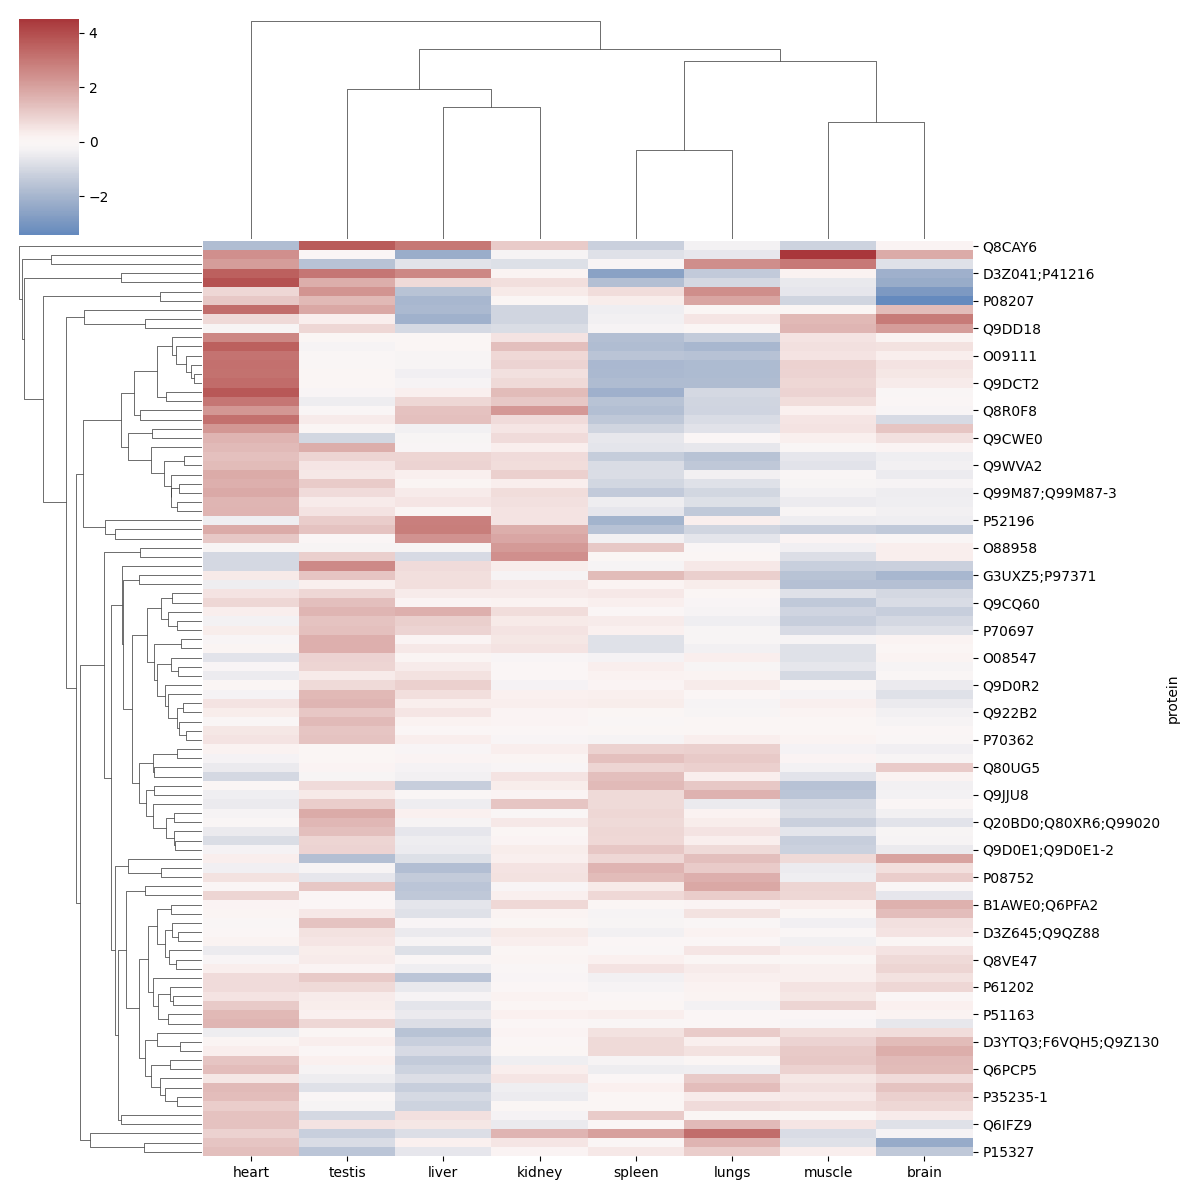

In [8]:
#display dfs as clustermaps
import seaborn as sns
import numpy as np

nan_mask = df_protein.set_index('protein').drop(columns=["p_value"]).isna()

sns.clustermap(df_protein.set_index('protein').drop(columns=["p_value"]).replace(np.nan, 0), cmap="vlag", center=0, figsize=(12, 12), row_cluster=True, col_cluster=True, mask=nan_mask)

## Investigating proteoform profiles using the proteoform results table

We define the proteoform with the most consistent peptides as the 'reference proteoform'. The pearson correlation coefficient between the reference proteoform and each other proteoform is calculated and reported under the 'corr_to_ref' column. In other words, the 'corr_to_ref' column says how similar a proteoform behaves as compared to another proteoform. We use one of the AlphaQuant utility functions to filter for the interesting proteoforms, meaning those with low correlation compared to the reference proteoform.

In [9]:
import alphaquant.multicond.multicond_utils as aq_multicond_utils

df_proteoform_low_corr = aq_multicond_utils.get_low_correlation_proteoform_df(proteoform_df=df_proteoform, 
                                                                              max_correlation=0.7, keep_reference_proteoform=True)
#we specified that we always keep also the reference proteoform
display(df_proteoform_low_corr)

,proteoform_id,peptides,number_of_peptides,corr_to_ref,is_reference,protein,liver,muscle,kidney,testis,heart,brain,spleen,lungs
6,A0A1B0GRR3;P62281_2,SEQ_DYLHYIR_,1,0.178492,False,A0A1B0GRR3;P62281,0.587350,-0.129996,0.012693,-0.072470,1.712760,-0.560123,0.186308,-0.096534
32,O08547_1,SEQ_LAFAYLEDLHSEFDEQHGK_,1,0.608774,False,O08547,-0.202806,0.481987,-0.260940,1.030155,-0.381012,0.507846,-0.160010,0.298740
37,O88456_1,SEQ_SGTIGSHELPGAFEAAGFHLNEHLYSMIIR_,1,0.579716,False,O88456,-0.155204,0.612952,-0.390919,0.229860,-0.352450,0.872345,-0.215971,1.083961
42,P05064_3,SEQ_VLAAVYK_,1,0.571404,False,P05064,1.007162,2.687787,0.781976,-1.372595,0.457796,0.445600,-2.344733,-1.913316
51,P08752_4,SEQ_TTGIVETHFTFK_,1,0.611505,False,P08752,-2.431615,1.823870,-0.024359,-1.282638,-0.483079,2.881259,0.370370,1.130297
60,P11499_2,SEQ_YIDQEELNK_;SEQ_EDQTEYLEER_;SEQ_ELISNASDALDK_,3,0.689649,False,P11499,0.050037,-0.821413,0.086973,0.918840,-0.039078,0.103948,0.012233,-0.040152
61,P11499_3,SEQ_HFSVEGQLEFR_;SEQ_HNDDEQYAWESSAGGSFTVR_,2,0.687336,False,P11499,-0.236168,0.220995,-0.029820,0.901015,-0.042406,0.496888,0.120184,0.071255
62,P11499_4,SEQ_EDQTEYLEERR_,1,0.201081,False,P11499,-0.400621,0.814720,0.016642,0.372100,-0.109835,0.168159,0.110176,0.150868
87,P60766_2,SEQ_NVFDEAILAALEPPEPK_,1,0.594589,False,P60766,-1.081504,-1.099082,0.283657,0.411113,-0.704463,-0.109896,0.593575,0.982087
96,Q05D44_1,SEQ_HLQAQGVEVPSK_,1,0.421984,False,Q05D44,1.516925,-0.646652,1.112979,1.099816,-0.800124,-0.390651,-0.899596,0.095378


Now, we can use this dataframe to plot the profiles of the low correlation proteoforms and their reference proteoforms. For this we make use of the alphaquant plotting functions.

In [10]:
import alphaquant.plotting.multicond as aq_plotting_multicond

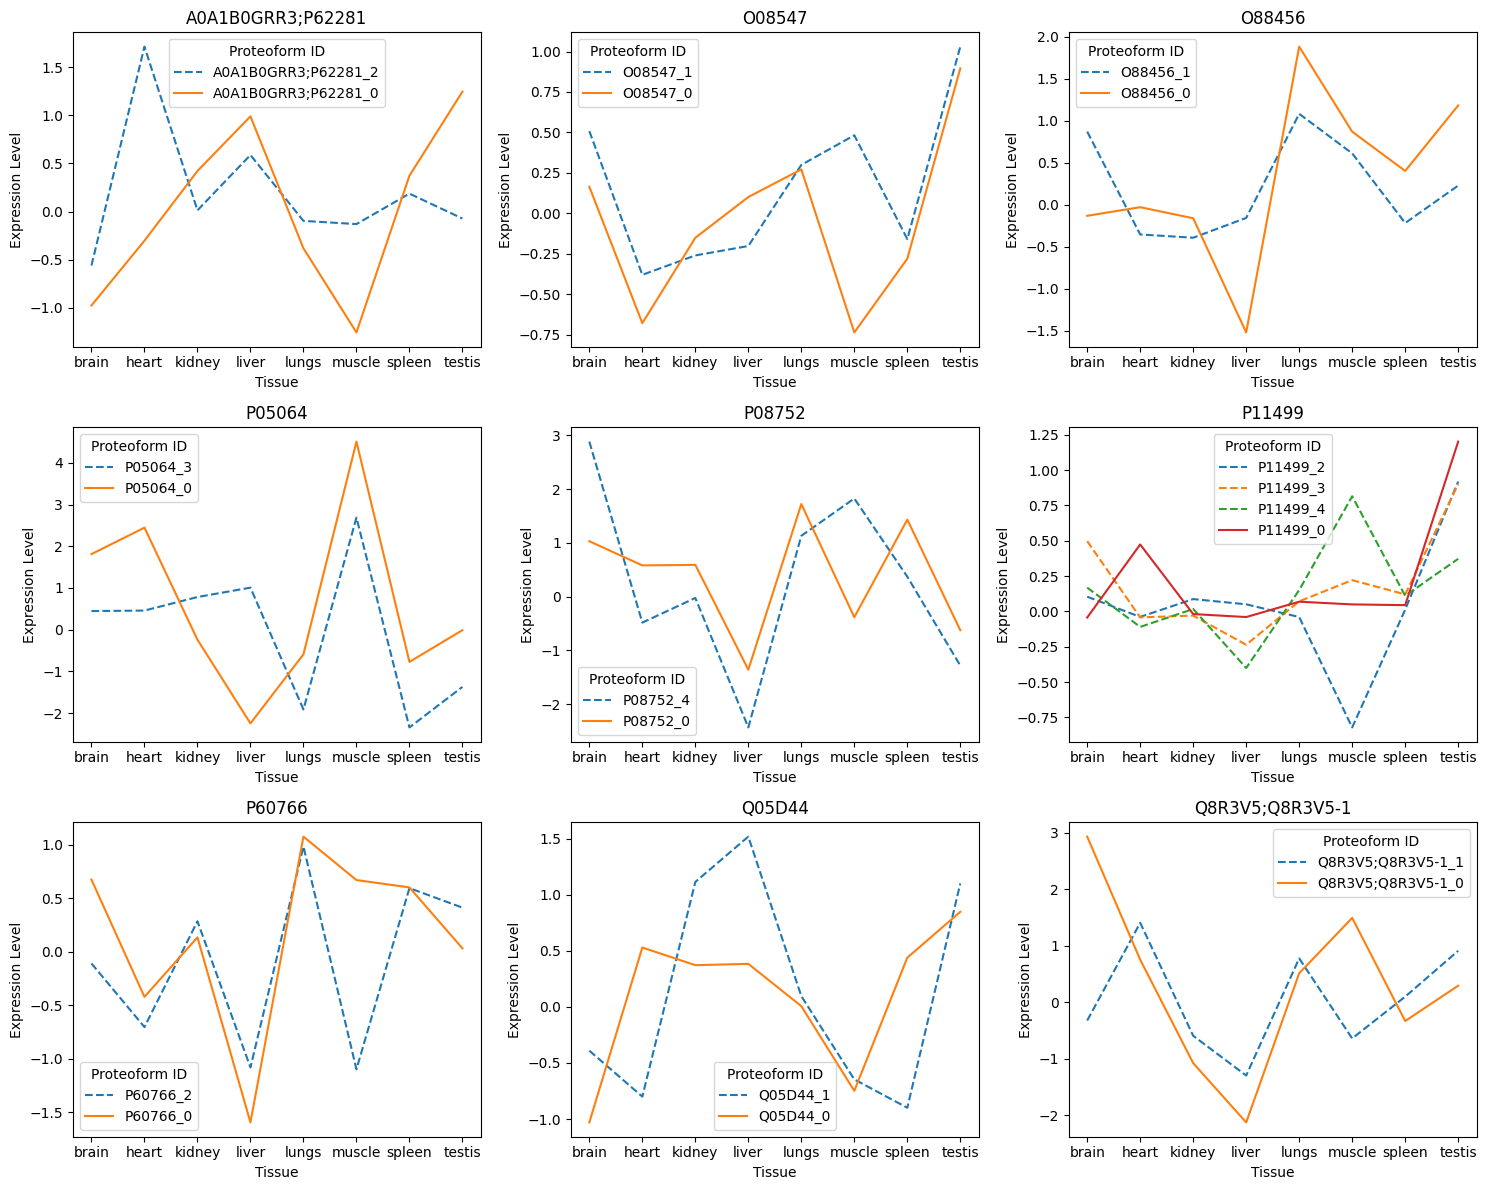

In [11]:
fig, ax = aq_plotting_multicond.plot_proteoform_intensity_profiles(proteoform_df=df_proteoform_low_corr)

